In [1120]:
from common_funcs import * # imports things like pandas, etc.
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GroupShuffleSplit
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
import imblearn.over_sampling, copy
import xgboost as xgb
import itertools as it
import matplotlib.patches as mpatches
%matplotlib inline

* [model test](#model_test)
* [create_roc_all](#create_roc_all)
* [run_xgb](#run_xgb)
* [run_model](#run_model)
* [gridCV](#gridCV)

In [2]:
def print_full(x):
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 2000)
    pd.set_option('display.float_format', '{:20,.2f}'.format)
    pd.set_option('display.max_colwidth', None)
    print(x)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.float_format')
    pd.reset_option('display.max_colwidth')
    
def full_print(x):
    return print_full(x)

Import Costa Rica poverty data set

In [3]:
df = pd.read_csv('data/train.csv', index_col=0)

In [4]:
# Look for columns with lots of null values
df.isna().sum().sort_values(ascending=False)

rez_esc            7928
v18q1              7342
v2a1               6860
SQBmeaned             5
meaneduc              5
                   ... 
abastaguafuera        0
abastaguadentro       0
cielorazo             0
techootro             0
Target                0
Length: 142, dtype: int64

There are three columns with tons of null values. Let's just drop. Let's also drop the columns with squared values. That seems redundant.

In [5]:
df = df.drop(columns=['rez_esc', 'v18q1', 'v2a1','SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 
                      'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned', 'agesq'], errors='ignore')

# Exploratory Data Analysis

What is the breakdown of poverty by household? That is, how many households within each category?

In the below bar chart, the poverty category is averaged by household. Because of errors in the data, some individuals in some households are marked as having a different poverty category than others in the same household. For the purposes of this preliminary EDA, the poverty category is simply averaged and rounded to the nearest whole number.

Since Category 1 is the most important to identify correctly, the bar chart suggests the classes are imbalanced.

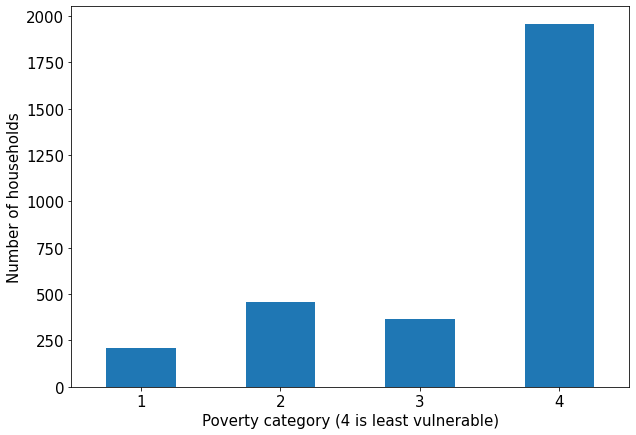

In [994]:
target_data = df.groupby('idhogar')['Target'].mean().value_counts();
target_data.index = list(map(round, list(target_data.index))); # round Target to nearest whole number
target_data.reset_index().groupby('index').sum().plot(kind='bar', figsize=(10,7));
plt.xlabel('Poverty category (4 is least vulnerable)');
plt.ylabel('Number of households');
plt.xticks(rotation=0);
plt.rc('font', size=15)
plt.gca().get_legend().remove()

# Cleaning
## Clean up Dependency column

Dependency seems like it could be important. This is defined as the number of adults divided by the number of children and elderly. Higher dependency could suggest greater poverty. This column contains a mixture of strings ('yes', 'no') and floats. Replace 'no' with 0 and 'yes' with the average of the other points PER POVERTY CATEGORY. As you can see below, 'yes', and 'no' are about 40% of the values for this column.

In [7]:
(df.dependency.value_counts()/df.dependency.count()).head()

yes    0.229361
no     0.182798
.5     0.156639
2      0.076384
1.5    0.074605
Name: dependency, dtype: float64

In [8]:
df.dependency = df.dependency.str.replace('no', '0')

In [9]:
# The non-yes values must be converted to floats to calculate mean.
dep_df = df[df.dependency != 'yes']
dep_df.dependency = dep_df.dependency.astype('float')
dep_means = dep_df.groupby('Target')['dependency'].mean()
dep_means

/opt/anaconda3/envs/metis/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Target
1    1.869565
2    1.820175
3    1.493852
4    0.889393
Name: dependency, dtype: float64

In [10]:
dep_means.loc[1]

1.869565218405797

In [11]:
def replace_yes(df):
    if df['dependency'] == 'yes':
        for i in range(1, 5):
            if df['Target'] == i:
                return dep_means.loc[i]
    else:
        return df.dependency

In [12]:
df.dependency = df.apply(replace_yes, axis=1).astype('float')

## Clean up Target column

When analyzing data, it makes sense to analyze by household (idhogar) because it wouldn't make sense that one person is poor but the rest of his household is not. So what we'll do is modify the df so that each person's poverty category is the mean of his household's but rounded to the nearest whole number.

In [13]:
# What happens here is the df is grouped by household, the Target is averaged and rounded, and merged back into 
# the original df
df = df.drop('Target', axis=1).merge(df.groupby('idhogar')['Target'].mean().map(round), on='idhogar')

# Back to some EDA
Does the household size affect poverty? Maybe larger households are more likely to be poor?

In [14]:
data = df.groupby('idhogar')[['tamhog', 'Target']].mean().groupby('Target').mean()
data.index = list(map(round, list(data.index)))

Text(0, 0.5, 'Number of households')

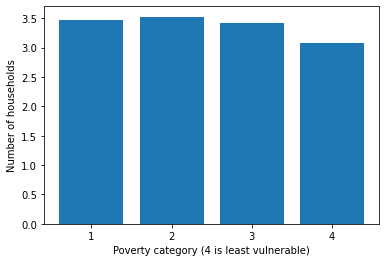

In [15]:
plt.bar(data.index, data.tamhog)
plt.xticks([1,2,3,4])
plt.xlabel('Poverty category (4 is least vulnerable)')
plt.ylabel('Number of households')

As you can see, the size of household does not make much difference in poverty categories. What about the ratio of adults to children in a household? Does a lower ratio mean greater chance of poverty? To answer these questions, we first need to create some functions that enable us to implement various models and then we can look at the effect of feature engineering on model performance.

# Modeling algorithms
## Classification Metrics
Presumably, it is more important to minimize the number of poor households that are missed (false negatives) than it is to provide aid to households that need it less than predicted. Therefore we will evaluate models by their RECALL. However, this is a multiclass classification problem so we will use a custom recall function that will serve as a weighted average of recalls for each class with the class of interest (poverty category 1) being of the most interest.

In [16]:
def recall(actuals, preds, class_):
    tp = np.sum((actuals == class_) & (preds == class_))
    fn = np.sum((actuals == class_) & (preds != class_))
    return tp / (tp + fn)

In [164]:
def macro_recall(actuals, preds, class_=1):
    # Weighted average of recalls for each poverty category
    
    recall_class = recall(actuals, preds, class_)
    
    recall_1 = recall(actuals, preds, 1)
    recall_2 = recall(actuals, preds, 2)
    recall_3 = recall(actuals, preds, 3)
    recall_4 = recall(actuals, preds, 4)
    
    all_recalls = [recall_1, recall_2, recall_3, recall_4]
    
    weights = []
    for weight in range(1, 5):
        if weight - class_ == 0:
            weights += [1]
        else:
            weights += [abs(weight - class_)]

    weights = 4 - np.array(weights)                    
    return np.dot(weights, all_recalls)/sum(weights)

## Data leakage
If we do a train-test randomly on the data, we will get significant leakage. This is because members of the same household have the same poverty category. Therefore, if members of a household get divided in a train-test split so that some members are in the training data and some are in the testing data, the model will not learn to predict poverty properly. It will predict poverty very accurately because members in the same household have many features in common such as type of dwelling or number of people in household. Therefore, poverty information from the testing data is present in the training data because people in the testing category have fellow household members in the training category, all with the same poverty score.

Therefore, we will use a GroupShuffleSplit that will split the data while keeping groups intact. So no household members will be in both training and testing data.

In [563]:
def train_test_split_group(X, y, n_splits=5, oversampling=False, random_state=42):
    
    '''return X_train_set, y_train_set, X_test_set, y_test_set'''
    
    gss = GroupShuffleSplit(n_splits=n_splits, test_size = 0.2, random_state=42)
    
    X_train_set = []
    y_train_set = []
    X_test_set = []
    y_test_set = []
       
    for train_ind, test_ind in gss.split(X,y,groups = X['idhogar']):
        X_train, y_train = X.iloc[train_ind], y.iloc[train_ind]
        X_train = X_train.drop('idhogar', axis=1, inplace=False) # don't set inplace=True bc it will throw copy warning
        
        if oversampling:
            ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = 'minority', random_state=random_state)
            X_train, y_train = ROS.fit_resample(X_train, y_train)
    
        X_test, y_test = X.iloc[test_ind], y.iloc[test_ind]
        X_test = X_test.drop('idhogar', axis=1, inplace=False)
        
        X_train_set += [X_train]
        y_train_set += [y_train]
        X_test_set += [X_test]
        y_test_set += [y_test]
    if n_splits==1: return X_train_set[0], y_train_set[0], X_test_set[0], y_test_set[0]
    return X_train_set, y_train_set, X_test_set, y_test_set

<a id="model_test"></a>

In [743]:
def model_test(model, X, y, n_splits=5, shuffle=True, random_state=42, oversampling=False, category=1):
    # returns a dict of a whole bunch of model performance data

    '''returns a dict of a whole bunch of model performance data 
    return {'ytest': y_test, 'y_predict_proba': y_predict_proba, 'feature_importance': feature_importance, 'recall_scores': cv_rf_recall,
           'recall_mean': np.mean(cv_rf_recall), 'recall_std': np.std(cv_rf_recall), 'kaggle_score': kaggle_score,
           'result_df': df, 'y_pred': y_pred, 'model': model}'''

    gss = GroupShuffleSplit(n_splits=n_splits, test_size = 0.2, random_state=42)

#    ----- Cross Validation -----
    cv_rf_recall, cv_rf_scale = [], []

    X_train_set, y_train_set, X_test_set, y_test_set = train_test_split_group(X, y, n_splits=n_splits, oversampling=oversampling)    
    for i in range(len(X_train_set)):
        X_train = X_train_set[i]
        X_test = X_test_set[i]
        y_train = y_train_set[i]
        y_test = y_test_set[i]
        
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        
        cv_rf_recall.append(float('%.3f'%macro_recall(y_test, y_pred, category)))
        
#     print(f'Recall scores for category {category}:', cv_rf_recall)
#     print(f'Simple mean cv r^2: {np.mean(cv_rf_recall):.3f} ± {np.std(cv_rf_recall):.3f}')
    
    
#     ----- Get general model performance parameters (not CV) -----   
    X_train, y_train, X_test, y_test = train_test_split_group(X, y, n_splits=1, oversampling=oversampling)    

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_predict_proba = model.predict_proba(X_test)
   
    feature_labels = list(X_train.columns)
    try:
        feature_importance = pd.DataFrame({'Feature' : feature_labels, 'Importance' : model.feature_importances_})
        feature_importance.sort_values(by='Importance', ascending=False, inplace=True)
    except Exception as e: print(e)
    
######     Calculate Kaggle score     ######

#     Kaggle score defined as the accuracy of the prediction ONLY for heads of household
    
    y_pred = pd.DataFrame(y_pred, columns=['Predict'], index=y_test.index)
#     df = X.join(y).join(y_pred)
    df = X_test.join(y_test).join(y_pred)
    
    kaggle_score = round(df[(df.Target == df.Predict) & (df.parentesco1 == 1)].shape[0] / df.shape[0], 3)
#     print('kaggle score:', kaggle_score)
    
    try:
        return {'ytest': y_test, 'y_predict_proba': y_predict_proba, 'feature_importance': feature_importance, 'recall_scores': cv_rf_recall,
           'recall_mean': np.mean(cv_rf_recall), 'recall_std': np.std(cv_rf_recall), 'kaggle_score': kaggle_score,
           'result_df': df, 'y_pred': y_pred, 'model': model}
    except:
        return {'ytest': y_test, 'y_predict_proba': y_predict_proba, 'recall_scores': cv_rf_recall,
           'recall_mean': np.mean(cv_rf_recall), 'recall_std': np.std(cv_rf_recall), 'kaggle_score': kaggle_score,
           'result_df': df, 'y_pred': y_pred, 'model': model}

* [model test](#model_test)
* [create_roc_all](#create_roc_all)
* [run_xgb](#run_xgb)
* [run_model](#run_model)
* [gridCV](#gridCV)
* [Hyperparameter plotting](#hyperPlotting)

In [19]:
%%html
<style>
  table {margin-left: 0 !important;}
</style>



Now that there's a modeling function in place, we can do some initial feature engineering. We'll start by looking at demographic features and see if adult/child proportion improves the model. We will also test the model function above. 

The below sub_df contains only features relating to demographics:

|Feature| Description |
| :-- | :--|
|r4h1	     |   Males younger than 12 years of age|
|r4h2	     |  Males 12 years of age and older|
|r4h3	     | Total males in the household    |
| r4m1	       | Females younger than 12 years of age
| r4m2	      |  Females 12 years of age and older
| r4m3	      |  Total females in the household
| r4t1	      |  persons younger than 12 years of age
| r4t2	      |  persons 12 years of age and older
| r4t3	      |  Total persons in the household
| dis        |   = 1 if disable person
| female	 |   = 1 if female
| estadocivil3|	=1 if married
| estadocivil4	|=1 if divorced
| estadocivil5	|=1 if separated
| estadocivil6	|=1 if widow/er
| estadocivil7|	=1 if single
| idhogar	  |  Household level identifier
| hogar_nin	  |  Number of children 0 to 19 in household
| hogar_adul	|Number of adults in household
| hogar_mayor	|# of individuals 65+ in the household
| hogar_total	|# of total individuals in the household
| dependency	|Dependency rate
| age	     |   Age in years

In [20]:
demog_df = df[['r4h1', 'r4h2', 'r4h3', 'r4m1', 'r4m2', 'r4m3', 'r4t1', 'r4t2', 'r4t3','age','female', 'dis',
               'estadocivil3', 'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 'parentesco1',
              'idhogar', 'hogar_nin', 'hogar_adul', 'hogar_mayor', 'hogar_total', 'dependency', 'Target']]

## Baseline modeling of demographic features

In [21]:
X = demog_df.groupby('idhogar').mean()
y = X.Target.astype('int')
X.drop('Target', axis=1, inplace=True)

In [22]:
model = RandomForestClassifier(n_estimators=100)
model_test(model, X, y);

Recall scores for category 1: [0.32, 0.324, 0.398, 0.358, 0.358]
Simple mean cv r^2: 0.352 ± 0.028
kaggle score: 0.013721552878179385


Good CV results but model doesn't fit well. Try some feature engineering for demographics info.

In [23]:
X['adult_child_proportion'] = X['hogar_adul'] / X['hogar_total']
X.drop(columns=['hogar_adul', 'hogar_total'], inplace=True)

In [24]:
model = RandomForestClassifier(n_estimators=100)
model_test(model, X, y);

Recall scores for category 1: [0.327, 0.337, 0.385, 0.353, 0.379]
Simple mean cv r^2: 0.356 ± 0.023
kaggle score: 0.013721552878179385


In [25]:
feature_names = list(X.columns)
feature_importance = pd.DataFrame({'Feature' : feature_names, 'Importance' : model.feature_importances_})
feature_importance.sort_values('Importance', ascending=False).head(10)

,Feature,Importance
9,age,0.349526
20,dependency,0.187951
16,estadocivil7,0.049470
11,dis,0.040037
21,adult_child_proportion,0.037089
14,estadocivil5,0.028461
12,estadocivil3,0.028188
10,female,0.028057
17,parentesco1,0.022712
18,hogar_nin,0.022051


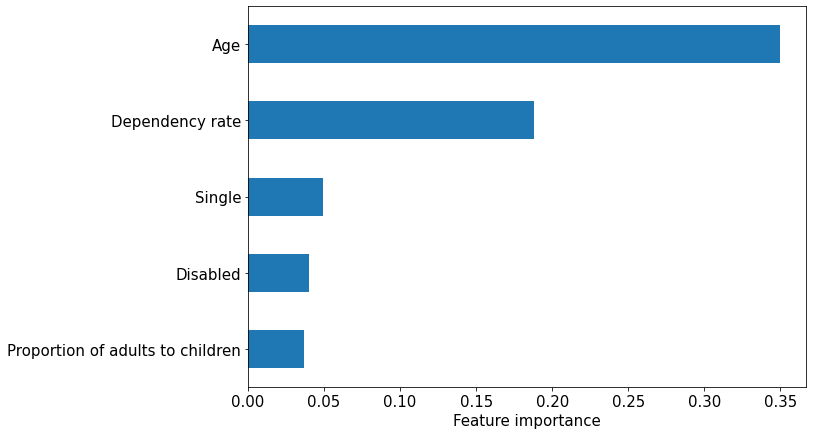

In [1011]:
demog_featureEng_table = feature_importance.sort_values('Importance', ascending=True).tail(5)#
demog_featureEng_table.Feature = ['Proportion of adults to children', 'Disabled', 'Single', 'Dependency rate', 'Age']
demog_featureEng_table.plot(x='Feature', kind='barh', figsize=(10,7));
plt.gca().get_legend().remove()
plt.xlabel('Feature importance');
plt.ylabel('');

It looks like new adult-child proportion feature does rank as more important than most of the original features but most of the importance goes to age and dependency. This makes sense. The older someone is, the less likely they are to be poor because the more resources they probably have. Similarly, the greater the dependency, the more demand on resources, the more likely they are to be poor. This relationship is already reflected in the dependency rate so calculating proportion of adults to children is slightly redundant. It just doesn't account for elderly.

# Evaluating model performance
We need functions that calculate model performance metrics, prioritizing recall as discussed above.
<a id="create_roc_all"></a>

In [1013]:
def merge_results(y_test, y_test_pred): 
    # This creates a X x 2 table containing a column for actual and predicted values
    y_test_df = pd.DataFrame(y_test)
    y_test_pred_df = pd.DataFrame(y_test_pred)
    y_test_pred_df.index = y_test_df.index
    merged_results_ = pd.concat([y_test_df, y_test_pred_df], axis=1, ignore_index=True)
    merged_results_.columns = ['Actual', 'Predicted']
    return merged_results_

def pred_x(y_pred_proba, alpha, x): 
    # creates a series containing a predicted category number for a given threshold and 0
#     if it does not meet the threshold
    # alpha is decision threshold
    # x is poverty category (1, 2, 3, 4)
    results = []
    x -= 1 # subtract 1 because column index starts at 0, not 1
    for i in range(y_pred_proba.shape[0]): # Loop through rows of predicted probabilities
        # loop through probabilities for the category being analyzed
        if y_pred_proba[i][x] >= alpha:
            results += [x + 1] # add back the 1 so it is stored as a column number in the list
        else:
            results += [0]
    return pd.Series(results)

def recall_multiclass(merged_results, x): # calculates recall for a given class x
#     display(merged_results) #####
    tp = merged_results[(merged_results.Actual == x) & (merged_results.Predicted == x)].shape[0]
    fn = merged_results[(merged_results.Actual == x) & (merged_results.Predicted != x)].shape[0]
    return tp / (tp + fn)

def fp_multiclass(merged_results, x): # calculates false positive rate for a give class x
    tn = merged_results[(merged_results.Actual != x) & (merged_results.Predicted != x)].shape[0]
    fp = merged_results[(merged_results.Actual != x) & (merged_results.Predicted == x)].shape[0]
    return fp / (fp + tn)

def create_roc(y_test, y_test_pred_proba, z):
    # z is the category number being analyzed
    x = []
    y = []
    for alpha in range(100):
        alpha /= 100
        # create df of actual and preds
        # loop through decision thresholds
        merged_results = merge_results(y_test, pred_x(y_test_pred_proba, alpha, z)) 
        x += [fp_multiclass(merged_results, z)]
        y += [recall_multiclass(merged_results, z)]
        
    plt.plot(x,y)

def create_roc_all(y_test, y_test_pred_proba, view=False):
    results = {}
    roc_data = {} # store ROC data points in dict and return it
    results['AUC'] = [-1]
    results['category'] = [-1]
    if view: plt.figure(figsize=(10, 7))

    for z in range(1,5):
        x = []
        y = []
        for alpha in range(100):
            # low alpha means high fp rate so loop is calculating points from right to left on ROC curve
            alpha /= 100
            merged_results = merge_results(y_test, pred_x(y_test_pred_proba, alpha, z))
            x += [fp_multiclass(merged_results, z)]
            y += [recall_multiclass(merged_results, z)]
            roc_data[z] = [x, y]
            
        if view:
            plt.plot(x,y)

#         ----- Calculate AUC -----
        xaxis = [i-j for i, j in zip(x[:-1], x[1:])]
        yaxis = y[1:]
        total = sum([xaxis[i] * yaxis[i] for i in range(len(xaxis))])

        results['AUC'] += [total]
        results['category'] += [z]

    if view:
        w = np.linspace(0, 1, 10)
        plt.plot(w, w, linestyle='--')
        plt.legend(range(1,5), loc='lower right', title='Category')
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC Curve')
        
    auc = pd.DataFrame(results).iloc[1:].reset_index(drop=True).set_index('category')
#     display(auc)
    return auc, roc_data

* [model test](#model_test)
* [create_roc_all](#create_roc_all)
* [run_xgb](#run_xgb)
* [run_model](#run_model)
* [gridCV](#gridCV)
* [Hyperparameter plotting](#hyperPlotting)

# Feature Engineering by Household and Individual features
Some columns are unique to the individual such as age, years of education, etc while other columns describe the individual's household characteristics. Additionally, the data set indicates what region the individual is in. A way to improve the model may be to see if there is any significance to how an individual's characteristics compare to others in the same geographic region. To do this, we will break down the data by region, scale each column, and build it back up into a data set for modeling.

In [28]:
locations = ['lugar1', 'lugar2', 'lugar3', 'lugar4', 'lugar5', 'lugar6']
# Create a df that is grouped by household. Then split df by location.
df_hogar = df.groupby('idhogar').mean()
df_hogar

,hacdor,rooms,hacapo,v14a,refrig,v18q,r4h1,r4h2,r4h3,r4m1,...,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,Target
idhogar,,,,,,,,,,,,,,,,,,,,,
001ff74ca,0.0,6.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,19.000000,4.0
003123ec2,0.0,3.0,0.0,1.0,1.0,0.0,2.0,1.0,3.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,12.750000,2.0
004616164,0.0,4.0,0.0,1.0,1.0,0.0,0.0,2.0,2.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,33.000000,2.0
004983866,0.0,5.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,37.500000,3.0
005905417,0.0,8.0,0.0,1.0,0.0,0.0,1.0,1.0,2.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,17.333333,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ff9343a35,0.0,5.0,0.0,1.0,1.0,1.0,0.0,3.0,3.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,39.500000,4.0
ff9d5ab17,0.0,5.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,19.666667,4.0
ffae4a097,0.0,3.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,61.000000,4.0


In [29]:
columns = ['abastaguadentro', 'abastaguafuera', 'abastaguano', 'age', 'area1', 'area2', 'bedrooms', 'cielorazo', 
           'computer', 'coopele', 'dependency', 'dis', 'elimbasu1', 'elimbasu2', 'elimbasu3', 'elimbasu4', 
           'elimbasu5', 'elimbasu6', 'energcocinar1', 'energcocinar2', 'energcocinar3', 'energcocinar4', 'epared1',
           'epared2', 'epared3', 'escolari', 'estadocivil1', 'estadocivil2', 'estadocivil3', 'estadocivil4', 
           'estadocivil5', 'estadocivil6', 'estadocivil7', 'etecho1', 'etecho2', 'etecho3', 'eviv1', 'eviv2', 
           'eviv3', 'female', 'hacapo', 'hacdor', 'hhsize', 'hogar_adul', 'hogar_mayor', 'hogar_nin', 'hogar_total',
           'instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 
           'instlevel8', 'instlevel9', 'male', 'meaneduc', 'mobilephone', 'noelec', 'overcrowding', 'paredblolad', 
           'pareddes', 'paredfibras', 'paredmad', 'paredother', 'paredpreb', 'paredzinc', 'paredzocalo', 
           'parentesco1', 'parentesco10', 'parentesco11', 'parentesco12', 'parentesco2', 'parentesco3', 
           'parentesco4', 'parentesco5', 'parentesco6', 'parentesco7', 'parentesco8', 'parentesco9', 'pisocemento',
           'pisomadera', 'pisomoscer', 'pisonatur', 'pisonotiene', 'pisoother', 'planpri', 'public', 'qmobilephone',
           'r4h1', 'r4h2', 'r4h3', 'r4m1', 'r4m2', 'r4m3', 'r4t1', 'r4t2', 'r4t3', 'refrig', 'rooms', 'sanitario1',
           'sanitario2', 'sanitario3', 'sanitario5', 'sanitario6', 'tamhog', 'tamviv', 'techocane', 'techoentrepiso',
           'techootro', 'techozinc', 'television', 'tipovivi1', 'tipovivi2', 'tipovivi3', 'tipovivi4', 'tipovivi5',
           'v14a', 'v18q']

In [30]:
list_df_hogar = []

# for each location, remove it from the list, drop all columns in the list, put the location back in
# this creates a df without location information which is unnecessary

for i, location in enumerate(locations):
    locations.remove(location)
    df_hogar_lugar = df_hogar[df_hogar[location] == 1]
    df_hogar_lugar.drop(columns=locations, inplace=True)
    list_df_hogar += [df_hogar_lugar]
    locations.insert(i, location)
    
# For the df for each location, remove any columns containing location info ('lugar') as well as the Target column
for i, dff in enumerate(list_df_hogar):
    scaler = StandardScaler()
    cols_to_remove = list(dff.columns[dff.columns.str.startswith('lugar')])
    cols_to_remove += ['Target']
    columns = [column for column in columns if column not in cols_to_remove]

    data = dff.drop(cols_to_remove, axis=1).values

    scaler.fit(data)
    data = scaler.transform(data)

    list_df_hogar[i] = pd.DataFrame(data, columns = columns, index = dff.index)    

/opt/anaconda3/envs/metis/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [31]:
# Assemble all the dfs for each location into one mother df
df_all_scaled = pd.DataFrame()
for sub_df in list_df_hogar:
    df_all_scaled = df_all_scaled.append(sub_df)

df_all_scaled

,abastaguadentro,abastaguafuera,abastaguano,age,area1,area2,bedrooms,cielorazo,computer,coopele,...,techootro,techozinc,television,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,v14a,v18q
idhogar,,,,,,,,,,,,,,,,,,,,,
006031de3,-0.133862,-0.694791,-0.095755,0.067554,0.191029,1.601492,1.452043,-0.317069,0.448657,1.385337,...,1.997165,-0.12711,-0.246664,-0.398187,-0.690008,0.223807,-0.354230,0.412431,-0.412431,-0.927517
006555fe2,-0.133862,0.633686,-0.095755,0.067554,0.191029,-0.624418,-0.446285,1.838754,1.401715,-0.453079,...,-0.500710,-0.12711,-0.246664,-0.398187,1.449259,0.223807,1.028917,0.412431,-0.412431,1.014145
00693f597,-0.133862,-0.694791,-0.095755,0.067554,0.191029,-0.624418,1.452043,0.760843,1.401715,-0.453079,...,1.997165,-0.12711,-0.246664,-0.398187,-0.690008,0.223807,0.337343,0.412431,-0.412431,-0.745661
009ae1cec,-0.133862,-0.694791,-0.095755,0.067554,0.191029,-0.624418,1.452043,-1.394980,-0.504401,-0.453079,...,-0.500710,-0.12711,4.054090,-0.398187,-0.690008,0.223807,-1.045804,0.412431,-0.412431,-1.179318
00e3e05c5,-0.133862,-0.030553,-0.095755,0.067554,0.191029,-0.624418,1.452043,-0.317069,0.448657,-0.453079,...,-0.500710,-0.12711,-0.246664,-0.398187,-0.690008,0.223807,-0.354230,0.412431,-0.412431,-0.880888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fdb13f946,-0.148413,0.356007,-0.148413,0.065795,0.307148,2.943920,-0.528651,-0.407007,-0.644998,-0.543462,...,-0.407221,-0.09325,-0.370479,5.669467,-0.414388,0.162938,0.501829,-0.697982,0.697982,0.524503
fe30c653f,-0.148413,1.805017,-0.148413,0.065795,0.307148,-0.339683,1.064168,2.606574,2.855344,1.207693,...,-0.407221,-0.09325,-0.370479,-0.176383,-0.414388,0.162938,-0.290173,-0.697982,0.697982,-0.893060
fef7fd222,-0.148413,0.356007,-0.148413,0.065795,0.307148,-0.339683,2.656987,-0.407007,1.105173,-0.543462,...,-0.407221,-0.09325,-0.370479,-0.176383,-0.414388,0.162938,-0.290173,-0.697982,0.697982,-1.157351


In [32]:
df_hogar[locations].sum()/df_hogar[locations].sum().sum()
# 60% of households are in lugar1

lugar1    0.589357
lugar2    0.090361
lugar3    0.065930
lugar4    0.084003
lugar5    0.092704
lugar6    0.077644
dtype: float64

In [33]:
# Rename scaled columns before integrating into the main df
df_all_scaled.columns = df_all_scaled.columns.map(lambda x: x + '_scaledLugar')
df_all_scaled

,abastaguadentro_scaledLugar,abastaguafuera_scaledLugar,abastaguano_scaledLugar,age_scaledLugar,area1_scaledLugar,area2_scaledLugar,bedrooms_scaledLugar,cielorazo_scaledLugar,computer_scaledLugar,coopele_scaledLugar,...,techootro_scaledLugar,techozinc_scaledLugar,television_scaledLugar,tipovivi1_scaledLugar,tipovivi2_scaledLugar,tipovivi3_scaledLugar,tipovivi4_scaledLugar,tipovivi5_scaledLugar,v14a_scaledLugar,v18q_scaledLugar
idhogar,,,,,,,,,,,,,,,,,,,,,
006031de3,-0.133862,-0.694791,-0.095755,0.067554,0.191029,1.601492,1.452043,-0.317069,0.448657,1.385337,...,1.997165,-0.12711,-0.246664,-0.398187,-0.690008,0.223807,-0.354230,0.412431,-0.412431,-0.927517
006555fe2,-0.133862,0.633686,-0.095755,0.067554,0.191029,-0.624418,-0.446285,1.838754,1.401715,-0.453079,...,-0.500710,-0.12711,-0.246664,-0.398187,1.449259,0.223807,1.028917,0.412431,-0.412431,1.014145
00693f597,-0.133862,-0.694791,-0.095755,0.067554,0.191029,-0.624418,1.452043,0.760843,1.401715,-0.453079,...,1.997165,-0.12711,-0.246664,-0.398187,-0.690008,0.223807,0.337343,0.412431,-0.412431,-0.745661
009ae1cec,-0.133862,-0.694791,-0.095755,0.067554,0.191029,-0.624418,1.452043,-1.394980,-0.504401,-0.453079,...,-0.500710,-0.12711,4.054090,-0.398187,-0.690008,0.223807,-1.045804,0.412431,-0.412431,-1.179318
00e3e05c5,-0.133862,-0.030553,-0.095755,0.067554,0.191029,-0.624418,1.452043,-0.317069,0.448657,-0.453079,...,-0.500710,-0.12711,-0.246664,-0.398187,-0.690008,0.223807,-0.354230,0.412431,-0.412431,-0.880888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fdb13f946,-0.148413,0.356007,-0.148413,0.065795,0.307148,2.943920,-0.528651,-0.407007,-0.644998,-0.543462,...,-0.407221,-0.09325,-0.370479,5.669467,-0.414388,0.162938,0.501829,-0.697982,0.697982,0.524503
fe30c653f,-0.148413,1.805017,-0.148413,0.065795,0.307148,-0.339683,1.064168,2.606574,2.855344,1.207693,...,-0.407221,-0.09325,-0.370479,-0.176383,-0.414388,0.162938,-0.290173,-0.697982,0.697982,-0.893060
fef7fd222,-0.148413,0.356007,-0.148413,0.065795,0.307148,-0.339683,2.656987,-0.407007,1.105173,-0.543462,...,-0.407221,-0.09325,-0.370479,-0.176383,-0.414388,0.162938,-0.290173,-0.697982,0.697982,-1.157351


In [34]:
# Reintegrate columns into the original df_hogar
df_hogar = df_hogar.merge(df_all_scaled, on='idhogar')
df_hogar

,hacdor,rooms,hacapo,v14a,refrig,v18q,r4h1,r4h2,r4h3,r4m1,...,techootro_scaledLugar,techozinc_scaledLugar,television_scaledLugar,tipovivi1_scaledLugar,tipovivi2_scaledLugar,tipovivi3_scaledLugar,tipovivi4_scaledLugar,tipovivi5_scaledLugar,v14a_scaledLugar,v18q_scaledLugar
idhogar,,,,,,,,,,,,,,,,,,,,,
001ff74ca,0.0,6.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,...,-0.395831,-0.109985,-0.389071,-0.214087,-0.498755,0.181444,-1.109354,-0.869048,0.869048,-1.014576
003123ec2,0.0,3.0,0.0,1.0,1.0,0.0,2.0,1.0,3.0,0.0,...,-0.410824,-0.121046,2.332780,-0.203355,-0.422757,0.172452,-0.258451,0.926855,-0.926855,-1.316898
004616164,0.0,4.0,0.0,1.0,1.0,0.0,0.0,2.0,2.0,0.0,...,-0.423130,-0.060971,3.201562,-0.174741,-0.464991,0.196116,-0.215941,-1.143544,1.143544,-0.348629
004983866,0.0,5.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,-0.496825,-0.205738,-0.407039,-0.231249,-0.520546,0.191943,-0.159555,0.661783,-0.661783,0.036414
005905417,0.0,8.0,0.0,1.0,0.0,0.0,1.0,1.0,2.0,0.0,...,-0.395831,-0.109985,2.570226,-0.214087,-0.498755,0.181444,-1.109354,-0.869048,0.869048,-1.108097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ff9343a35,0.0,5.0,0.0,1.0,1.0,1.0,0.0,3.0,3.0,0.0,...,-0.500710,-0.127110,-0.246664,-0.398187,1.449259,0.223807,1.028917,0.412431,-0.412431,-0.032226
ff9d5ab17,0.0,5.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,...,2.434132,-0.121046,-0.428673,-0.203355,-0.422757,0.172452,-0.258451,0.926855,-0.926855,-0.917040
ffae4a097,0.0,3.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,-0.407221,-0.093250,-0.370479,-0.176383,-0.414388,0.162938,-0.290173,-0.697982,0.697982,1.365431


Now we need to merge the grouped df back into the original df. The grouped df should be broken up into individual attributes and household attributes. The individual attributes and scaled individual attributes should be dropped. The grouped df should contain household attributes and scaled household attributes.



The new merged df should contain columns for each individual as follows: 
* household features
* household features scaled according to geographical area
* individual features
* individual features scaled by geographical area


In [36]:
individual_cols = ['age'] #+ locations
individual_cols += '''v18q, escolari, dis, male, female, estadocivil1, estadocivil2, 
                    estadocivil3, estadocivil4, estadocivil5, estadocivil6, estadocivil7, parentesco1, 
                    parentesco2, parentesco3, parentesco4, parentesco5, parentesco6, parentesco7, parentesco8, 
                    parentesco9, parentesco10, parentesco11, parentesco12'''.split(',')
individual_cols = [col.strip() for col in individual_cols]
individual_cols += list(map(lambda x: x + '_scaledLugar', individual_cols))

hh_columns = [col for col in df_hogar.columns if col not in individual_cols]

In [40]:
df_hogar[individual_cols].head()

,age,v18q,escolari,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,...,parentesco3_scaledLugar,parentesco4_scaledLugar,parentesco5_scaledLugar,parentesco6_scaledLugar,parentesco7_scaledLugar,parentesco8_scaledLugar,parentesco9_scaledLugar,parentesco10_scaledLugar,parentesco11_scaledLugar,parentesco12_scaledLugar
idhogar,,,,,,,,,,,,,,,,,,,,,
001ff74ca,19.000000,1.0,8.000000,0.0,0.000000,1.000000,0.500000,0.0,0.0,0.0,...,-0.751413,-0.254532,2.406258,-0.277933,-0.985213,0.410853,-1.079406,-1.729138,1.729138,1.957547
003123ec2,12.750000,0.0,3.250000,0.0,0.750000,0.250000,0.500000,0.5,0.0,0.0,...,-0.662352,-0.287406,-0.441732,-0.216116,-1.051844,-0.619789,0.399986,0.926659,-0.926659,2.117102
004616164,33.000000,0.0,7.000000,0.0,1.000000,0.000000,0.000000,0.0,0.0,0.0,...,-0.680204,-0.216733,-0.382372,3.079199,0.501329,0.413192,-1.077580,1.969748,-1.969748,-0.603578
004983866,37.500000,0.0,7.500000,0.0,0.500000,0.500000,0.000000,0.0,0.0,0.0,...,-0.707171,-0.223080,-0.446402,2.492116,0.662690,0.315190,-1.031230,0.015222,-0.015222,-0.666876
005905417,17.333333,0.0,5.666667,0.0,0.666667,0.333333,0.333333,0.0,0.0,0.0,...,-0.751413,-0.254532,1.468561,-0.277933,0.139239,-0.267584,-1.079406,0.751910,-0.751910,1.071284


In [41]:
df_hogar[hh_columns].head()

,hacdor,rooms,hacapo,v14a,refrig,r4h1,r4h2,r4h3,r4m1,r4m2,...,techoentrepiso_scaledLugar,techootro_scaledLugar,techozinc_scaledLugar,television_scaledLugar,tipovivi1_scaledLugar,tipovivi2_scaledLugar,tipovivi3_scaledLugar,tipovivi4_scaledLugar,tipovivi5_scaledLugar,v14a_scaledLugar
idhogar,,,,,,,,,,,,,,,,,,,,,
001ff74ca,0.0,6.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,...,-0.243047,-0.395831,-0.109985,-0.389071,-0.214087,-0.498755,0.181444,-1.109354,-0.869048,0.869048
003123ec2,0.0,3.0,0.0,1.0,1.0,2.0,1.0,3.0,0.0,1.0,...,-0.161015,-0.410824,-0.121046,2.332780,-0.203355,-0.422757,0.172452,-0.258451,0.926855,-0.926855
004616164,0.0,4.0,0.0,1.0,1.0,0.0,2.0,2.0,0.0,0.0,...,-0.282843,-0.423130,-0.060971,3.201562,-0.174741,-0.464991,0.196116,-0.215941,-1.143544,1.143544
004983866,0.0,5.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,...,-0.265805,-0.496825,-0.205738,-0.407039,-0.231249,-0.520546,0.191943,-0.159555,0.661783,-0.661783
005905417,0.0,8.0,0.0,1.0,0.0,1.0,1.0,2.0,0.0,1.0,...,-0.243047,-0.395831,-0.109985,2.570226,-0.214087,-0.498755,0.181444,-1.109354,-0.869048,0.869048


Recall the features I need in the final df for modeling are:
* household features
* household features scaled according to geographical area
* individual features
* individual features scaled by geographical area

I have the first 3, I need to make the last one.

In [42]:
list_df_individual = []

for i, location in enumerate(locations):
    locations.remove(location)
    df_individual = df[df[location] == 1]
    df_individual.drop(columns=locations, inplace=True)
    list_df_individual += [df_individual]
    locations.insert(i, location)

# Assemble dfs for each location back into one large df for merging with df_hogar (household df)
for i, dff in enumerate(list_df_individual):
    scaler = StandardScaler()
    cols_to_remove = list(dff.columns[dff.columns.str.startswith('lugar')])
    # Remove edjefe, edjefa because they are household values.
    cols_to_remove += ['Target', 'idhogar', 'edjefe', 'edjefa']
    columns = [column for column in columns if column not in cols_to_remove]
    data = dff.drop(cols_to_remove, axis=1).values
    scaler.fit(data)
    data = scaler.transform(data)
    list_df_individual[i] = pd.DataFrame(data, columns = columns, index = dff.index)

/opt/anaconda3/envs/metis/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [43]:
df_all_scaled_individual = pd.DataFrame()
for sub_df in list_df_individual:
    df_all_scaled_individual = df_all_scaled_individual.append(sub_df)

df_all_scaled_individual

,abastaguadentro,abastaguafuera,abastaguano,age,area1,area2,bedrooms,cielorazo,computer,coopele,...,techootro,techozinc,television,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,v14a,v18q
0,-0.179869,-1.471945,-0.138032,0.059783,0.164519,-0.647778,-0.530006,-0.549545,-0.782952,-0.563508,...,1.963144,-0.139366,-0.239226,-0.409350,-0.730758,0.168473,-1.274317,0.410535,-0.410535,0.345883
1,-0.179869,-0.812107,-0.138032,0.059783,0.164519,1.543740,-0.530006,-0.549545,-0.782952,-0.563508,...,1.963144,-0.139366,-0.239226,-0.409350,-0.730758,0.168473,-1.274317,0.410535,-0.410535,1.449147
2,-0.179869,1.827242,-0.138032,0.059783,0.164519,-0.647778,-0.530006,-1.510093,-1.636086,-0.563508,...,-0.509387,-0.139366,-0.239226,-0.409350,-0.730758,-5.935677,-1.922088,0.410535,-0.410535,2.598380
3,-0.179869,-0.152270,-0.138032,0.059783,0.164519,1.543740,-0.530006,0.411004,0.070183,0.962366,...,1.963144,-0.139366,-0.239226,-0.409350,-0.730758,0.168473,0.021223,0.410535,-0.410535,-0.849319
4,-0.179869,-0.152270,-0.138032,0.059783,0.164519,1.543740,-0.530006,0.411004,0.070183,0.962366,...,1.963144,-0.139366,-0.239226,-0.409350,-0.730758,0.168473,0.021223,0.410535,-0.410535,0.070067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9552,-0.208091,0.891294,-0.194126,0.080792,0.320943,-0.333093,-0.659422,0.281318,-0.135801,0.870407,...,2.464426,-0.102396,-0.335491,-0.175353,2.364264,0.125739,0.224777,-0.688613,0.688613,0.686339
9553,-0.208091,0.891294,-0.194126,0.080792,0.320943,-0.333093,-0.659422,0.281318,-0.135801,0.870407,...,2.464426,-0.102396,-0.335491,-0.175353,2.364264,0.125739,0.224777,-0.688613,0.688613,-1.411829
9554,-0.208091,0.891294,-0.194126,0.080792,0.320943,-0.333093,-0.659422,0.281318,-0.135801,0.870407,...,2.464426,-0.102396,-0.335491,-0.175353,2.364264,0.125739,0.224777,-0.688613,0.688613,0.877082
9555,-0.208091,0.891294,-0.194126,0.080792,0.320943,-0.333093,-0.659422,0.281318,-0.135801,0.870407,...,2.464426,-0.102396,-0.335491,-0.175353,2.364264,0.125739,0.224777,-0.688613,0.688613,-0.267374


Now select all individual attribute columns and add scaledLugar suffix

In [44]:
df_all_scaled_individual.columns = df_all_scaled_individual.columns.map(lambda x: x + '_scaledLugar')

In [45]:
# Join the original df with the scaled one. The new df will contain both individual and household columns scaled
# and unscaled but we will correct this later.
df.join(df_all_scaled_individual).head()

,hacdor,rooms,hacapo,v14a,refrig,v18q,r4h1,r4h2,r4h3,r4m1,...,techootro_scaledLugar,techozinc_scaledLugar,television_scaledLugar,tipovivi1_scaledLugar,tipovivi2_scaledLugar,tipovivi3_scaledLugar,tipovivi4_scaledLugar,tipovivi5_scaledLugar,v14a_scaledLugar,v18q_scaledLugar
0,0,3,0,1,1,0,0,1,1,0,...,1.963144,-0.139366,-0.239226,-0.40935,-0.730758,0.168473,-1.274317,0.410535,-0.410535,0.345883
1,0,4,0,1,1,1,0,1,1,0,...,1.963144,-0.139366,-0.239226,-0.40935,-0.730758,0.168473,-1.274317,0.410535,-0.410535,1.449147
2,0,8,0,1,1,0,0,0,0,0,...,-0.509387,-0.139366,-0.239226,-0.40935,-0.730758,-5.935677,-1.922088,0.410535,-0.410535,2.598380
3,0,5,0,1,1,1,0,2,2,1,...,1.963144,-0.139366,-0.239226,-0.40935,-0.730758,0.168473,0.021223,0.410535,-0.410535,-0.849319
4,0,5,0,1,1,1,0,2,2,1,...,1.963144,-0.139366,-0.239226,-0.40935,-0.730758,0.168473,0.021223,0.410535,-0.410535,0.070067


In [48]:
# Add the idhogar column for later merging with df_hogar
df_individual_merged = df.join(df_all_scaled_individual)[individual_cols].join(df.idhogar)

In [49]:
df_merge_final = df_individual_merged.merge(df_hogar[hh_columns], left_on='idhogar', right_index=True)

In [54]:
# Check for NaN values first before finalizing the df for analysis.
df_merge_final.isna().any()[df_merge_final.isna().any()]

meaneduc            True
r4t1_scaledLugar    True
dtype: bool

In [56]:
# How many NaN are in these columns?
df_merge_final[['meaneduc', 'r4t1_scaledLugar']].isna().sum()

meaneduc            5
r4t1_scaledLugar    5
dtype: int64

In [57]:
# 5 missing values out of 9500 so let's just fill these with the mean of the other values and move on
df_merge_final.meaneduc.fillna(df_merge_final.meaneduc.mean(), inplace=True)
df_merge_final.r4t1_scaledLugar.fillna(df_merge_final.r4t1_scaledLugar.mean(), inplace=True)

In [58]:
# Finally, drop the idhogar column because it is no longer needed. Save as pickle.

df_merge_final.drop('idhogar', axis=1, inplace=True, errors='ignore')
df_merge_final.to_pickle('data/df_merge_final')

Now we need a function that we will use to test multiple models. The function will generate performance metrics like recall and roc and auc.

# Modeling
Now we will create functions to run and evaluate various models.

<a id=run_model></a>

In [1159]:
def run_model(model, df, n_splits=5, shuffle=True, random_state=42, oversampling=False, category=1, view=False):
    
    '''    return {'ytest': ytest, 'y_predict_proba': y_predict_proba, 'feature_importance': feature_importance, 'recall_scores': cv_rf_recall,
           'recall_mean': np.mean(cv_rf_recall), 'recall_std': np.std(cv_rf_recall), 'kaggle_score': kaggle_score,
           'result_df': df, 'y_pred': y_pred, 'model': model} '''
    
    X = df.drop('Target', axis=1)
    y = df.Target.astype('int')
    results = model_test(model, X, y, n_splits=5, shuffle=True, random_state=42, oversampling=oversampling, category=1)
#     print(results)
    results['AUC'], roc_data = create_roc_all(results['ytest'], results['y_predict_proba'], view=view)
#     print('-----Cross-validation recall scores-----\n', results['recall_scores'])
    
    recall_mean = round(results['recall_mean'], 3)
    recall_std = round(results['recall_std'], 3)
    kaggle_score = results['kaggle_score']
    
    try:
        cumsum = results['feature_importance'].Importance.cumsum()
        cumsum.name = 'Cumulative sum'
        results['feature_importance'] = results['feature_importance'].join(cumsum)
    except Exception as e: print(e)
    
    if view:
        print('----- Recall Cross-Validation Scores -----')
        print(results['recall_scores'])
        print(f'Mean recall: {recall_mean} ± {recall_std}')
        print(f'Estimated Kaggle score: {kaggle_score}')    
        try: display(results['feature_importance'])
        except Exception as e: print(e)
        display(results['AUC'])

    return results, roc_data

* [model test](#model_test)
* [create_roc_all](#create_roc_all)
* [run_xgb](#run_xgb)
* [run_model](#run_model)
* [gridCV](#gridCV)
* [Hyperparameter plotting](#hyperPlotting)

----- Recall Cross-Validation Scores -----
[0.33, 0.364, 0.378, 0.33, 0.336]
Mean recall: 0.348 ± 0.02
Estimated Kaggle score: 0.228


,Feature,Importance,Cumulative sum
121,dependency,0.063287,0.063287
222,r4m3_scaledLugar,0.049193,0.112480
166,elimbasu6_scaledLugar,0.037434,0.149914
223,r4t1_scaledLugar,0.021956,0.171870
122,meaneduc,0.021436,0.193305
...,...,...,...
107,elimbasu6,0.000007,0.999991
78,pisonatur,0.000006,0.999997
84,techootro,0.000003,1.000000
197,mobilephone_scaledLugar,0.000000,1.000000


,AUC
category,
1,0.774009
2,0.809259
3,0.737582
4,0.880925


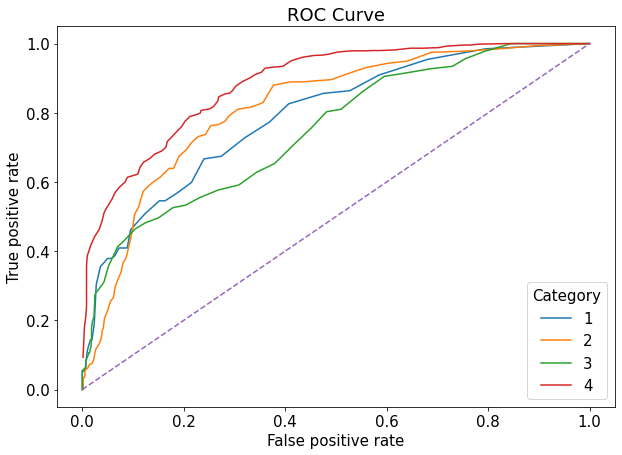

In [1014]:
results, roc_data = run_model(RandomForestClassifier(n_estimators=100), df_merge_final.join(df.idhogar), oversampling=False, view=True)

(0.5, 1.0)

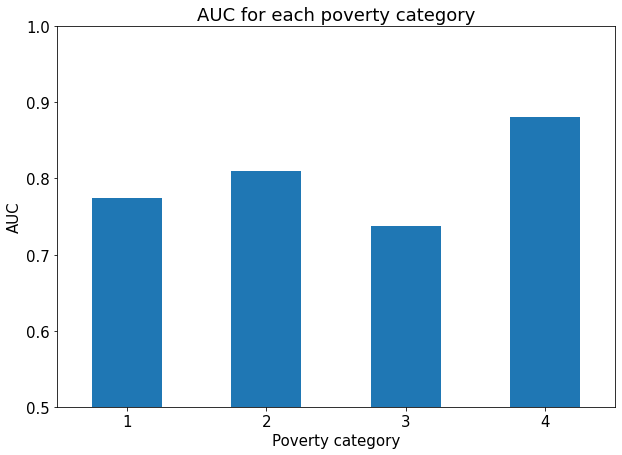

In [1022]:
results['AUC'].plot(kind='bar', figsize=(10,7));
ax = plt.gca()
ax.get_legend().remove()
plt.xticks(rotation=0);
plt.xlabel('Poverty category');
plt.ylabel('AUC');
plt.title('AUC for each poverty category');
ax.set_ylim([0.5,1.0])

In [400]:
# Check that no null values were predicted by the model
results['y_pred'].isna().sum()

Predict    0
dtype: int64

In [401]:
# Check to ensure Target variable did not sneak into the feature columns
'Target' in results['feature_importance'].Feature

False

## Modeling with truncated data set based on feature importance
Let's do further modeling on data but only on the features that rank highly in importance. No sense in testing 250 features if most of them don't contribute. We will speed up computation time by eliminating some features.

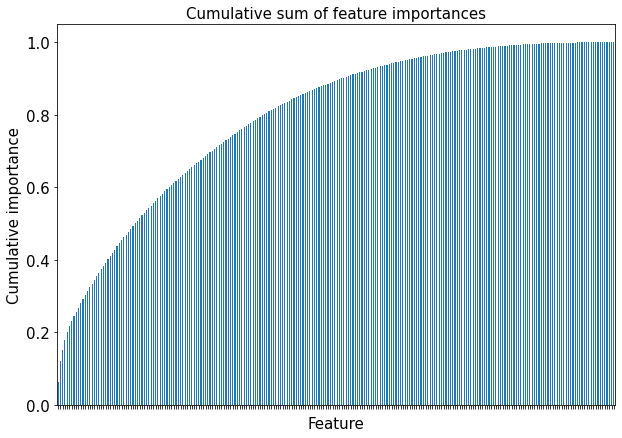

In [414]:
results['feature_importance']['Cumulative sum'].plot(kind='bar', figsize=(10, 7))
plt.gca().set(xticklabels=[]);
plt.rc('font', size=20)
plt.xlabel('Feature')
plt.ylabel('Cumulative importance', fontsize=15)
plt.title('Cumulative sum of feature importances', fontsize=15);

Features show a diminishing return. Let's do modeling with features up to 80% of total importance.

In [418]:
# features_modeling = results['feature_importance']['Cumulative sum']
features = results['feature_importance']['Cumulative sum']
features = features[features < 0.8]
# The index of this is the column number of the feature.

In [775]:
features.shape

(91,)

There are 91 features that account for 80% of feature importance. Or in other words, 37% of columns account for 80% of feature importance. Which features are most important?

In [1187]:
detailed_feature_rankings = feature_rankings.head(10).copy()
detailed_feature_rankings['Translation'] = pd.Series(['Total females in household (scaled)',
    'Measure of adults to number of dependents (i.e. children, eldery)',
    'If rubbish disposal by other means (scaled)',
    'Average years of education for adults (18+) (scaled)', 'Persons younger than 12 years of age',
    'Years of schooling', 'If toilet connected to black hole or letrine (scaled)', 'Owns a tablet (scaled)', 'Age', 
    'If dwelling is in precarious state (scaled)'])
detailed_feature_rankings

,Feature,Importance,Cumulative sum,Translation
0,r4m3_scaledLugar,0.039888,0.039888,Total females in household (scaled)
1,dependency,0.035787,0.075675,Measure of adults to number of dependents (i.e...
2,elimbasu6_scaledLugar,0.034231,0.109906,If rubbish disposal by other means (scaled)
3,meaneduc,0.028139,0.138045,Average years of education for adults (18+) (s...
4,r4t1_scaledLugar,0.024247,0.162292,Persons younger than 12 years of age
5,escolari,0.021393,0.183685,Years of schooling
6,sanitario5_scaledLugar,0.017206,0.200890,If toilet connected to black hole or letrine (...
7,v18q_scaledLugar,0.016835,0.217725,Owns a tablet (scaled)
8,age,0.015432,0.233157,Age
9,tipovivi4_scaledLugar,0.013155,0.246312,If dwelling is in precarious state (scaled)


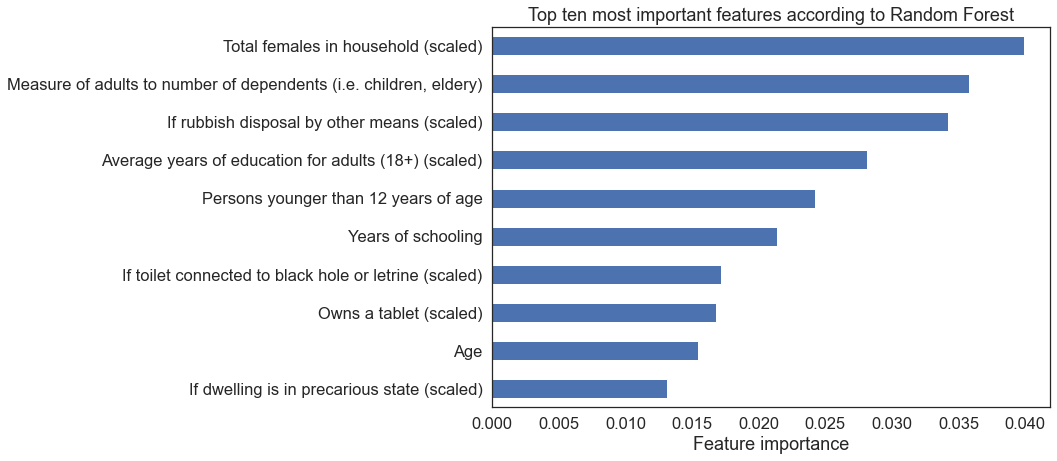

In [1188]:
detailed_feature_rankings[['Importance', 'Translation']].sort_values('Importance', ascending=True).plot(kind='barh', x='Translation')
plt.ylabel(''); plt.gca().get_legend().remove()
plt.xlabel('Feature importance');
plt.title('Top ten most important features according to Random Forest');

In [492]:
df_merge_select_features = df_merge_final.iloc[:,features.index]

# XGBoost
Let's try a more complicated model like XGBoost

<a id="run_xgb"></a>

In [489]:
# Copied from Metis lesson on XGBoost
def run_xgb(df,
            n_estimators=30000, #arbitrary large number
            max_depth=3,
            objective="multi:softmax",  # Other options: https://xgboost.readthedocs.io/en/latest/parameter.html#learning-task-parameters
            learning_rate=.1, 
            subsample=1,
            min_child_weight=1,
            colsample_bytree=.8
            ):
    gbm = xgb.XGBRegressor( 
                       n_estimators=n_estimators, #arbitrary large number
                       max_depth=max_depth,
                       objective=objective,
                       learning_rate=learning_rate, 
                       subsample=subsample,
                       min_child_weight=min_child_weight,
                       colsample_bytree=colsample_bytree,
                        num_class = 4,
                      )
    X = df.drop('Target', axis=1)
    y = df.Target.astype('int')
    
    y  = y.apply(lambda x: x-1)
    X_train, y_train, X_test, y_test = train_test_split_group(X, y, 1)
#     gss = GroupShuffleSplit(n_splits=1, test_size = 0.2, random_state=42)
#     for train_ind, test_ind in gss.split(X,y,groups = X['idhogar']):
#         pass

#     X_train = X.iloc[train_ind]; y_train = y.iloc[train_ind]; X_test = X.iloc[test_ind]; y_test = y.iloc[test_ind];
#     X_train.drop('idhogar', axis=1, inplace=True)
#     X_test.drop('idhogar', axis=1, inplace=True)

    eval_set=[(X_train,y_train),(X_test,y_test)] #tracking train/validation error as we go
    
    fit_model = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
#                     eval_metric='rmse',
                    early_stopping_rounds=20,
                    
                    verbose=False #gives output log as below
                   )
    return gbm

* [model test](#model_test)
* [create_roc_all](#create_roc_all)
* [run_xgb](#run_xgb)
* [run_model](#run_model)
* [gridCV](#gridCV)
* [Hyperparameter plotting](#hyperPlotting)

In [490]:
gbm = run_xgb(df_merge_select_features.join([df.Target, df.idhogar]))

/opt/anaconda3/envs/metis/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


[12:40:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [541]:
y = df.Target
X = df_merge_select_features.drop('Target', axis=1, errors='ignore')
X = X.join(df.idhogar) # Add idhogar to assist train-test-split-group
# display(X)
xtrain, ytrain, xtest, ytest = train_test_split_group(X, y, 1)
model.fit(xtrain, ytrain)
# display(xtest)
y_pred = gbm.predict(xtest)
macro_recall(ytest, y_pred)
# y_predict_proba = gbm.predict_proba(xtest)
# auc, roc_data = create_roc_all(ytest, y_predict_proba)

0.282690155738294

This score is not appreciably higher than Random Forest and since model improvement is probably best accomplished by cleaning and feature engineering and considering that XGB takes a long time to run and requires lots of tuning, we will leave this as an exercise for another time and for now proceed to evaluating models and feature engineering strategies.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

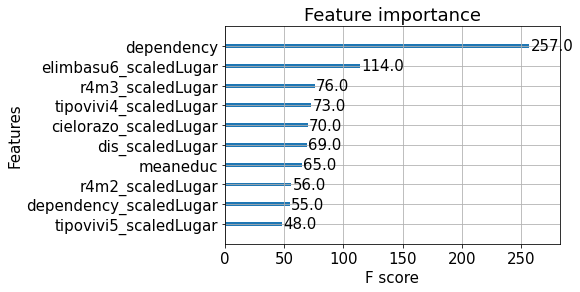

In [986]:
xgb.plot_importance(gbm, max_num_features=10)

Looks like there is some agreement in features between Random Forest and XGBoost.

# Calculating performance just based on heads of household
(How Kaggle scores)

Considering the Kaggle score is calculated using only heads of household, what if we just train on that?

In [537]:
df_hhh = df_merge_final.join(df.idhogar)
df_hhh = df_hhh[df_hhh.parentesco1 == 1]
df_hhh

,age,v18q,escolari,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,...,techootro_scaledLugar,techozinc_scaledLugar,television_scaledLugar,tipovivi1_scaledLugar,tipovivi2_scaledLugar,tipovivi3_scaledLugar,tipovivi4_scaledLugar,tipovivi5_scaledLugar,v14a_scaledLugar,idhogar
0,43,0,10,0,1,0,0,0,0,1,...,1.997165,-0.12711,-0.246664,-0.398187,-0.690008,0.223807,-1.045804,0.412431,-0.412431,21eb7fcc1
1,67,1,12,0,1,0,0,0,0,1,...,1.997165,-0.12711,-0.246664,-0.398187,-0.690008,0.223807,-1.045804,0.412431,-0.412431,0e5d7a658
2,92,0,11,1,0,1,0,0,0,0,...,-0.500710,-0.12711,-0.246664,-0.398187,-0.690008,-4.468141,-1.737378,0.412431,-0.412431,2c7317ea8
5,38,1,11,0,1,0,0,1,0,0,...,1.997165,-0.12711,-0.246664,-0.398187,-0.690008,0.223807,0.337343,0.412431,-0.412431,2b58d945f
8,30,0,9,0,1,0,0,1,0,0,...,1.997165,-0.12711,-0.246664,-0.398187,-0.690008,0.223807,-1.045804,0.412431,-0.412431,d6dae86b7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9535,26,0,5,0,0,1,0,1,0,0,...,-0.407221,-0.09325,-0.370479,-0.176383,2.413199,0.162938,-0.290173,-0.697982,0.697982,9bbf7c6ca
9541,40,0,2,1,1,0,0,1,0,0,...,-0.407221,-0.09325,-0.370479,-0.176383,-0.414388,0.162938,-0.290173,-0.697982,0.697982,e87e70c06
9545,45,0,2,0,1,0,0,1,0,0,...,-0.407221,-0.09325,-0.370479,-0.176383,-0.414388,0.162938,0.501829,-0.697982,0.697982,a8eeafc29
9551,67,0,0,0,1,0,0,0,1,0,...,-0.407221,-0.09325,-0.370479,-0.176383,-0.414388,0.162938,-0.290173,-0.697982,0.697982,212db6f6c


----- Recall Cross-Validation Scores -----
[0.307, 0.315, 0.303, 0.288, 0.332]
Mean recall: 0.309 ± 0.014
Estimated Kaggle score: 0.706


,Feature,Importance,Cumulative sum
222,r4m3_scaledLugar,0.037084,0.037084
166,elimbasu6_scaledLugar,0.035035,0.072119
121,dependency,0.033497,0.105616
122,meaneduc,0.022649,0.128266
223,r4t1_scaledLugar,0.020318,0.148583
...,...,...,...
78,pisonatur,0.000000,1.000000
77,pisoother,0.000000,1.000000
6,estadocivil1,0.000000,1.000000
106,elimbasu5,0.000000,1.000000


,AUC
category,
1,0.787631
2,0.787575
3,0.724499
4,0.896671


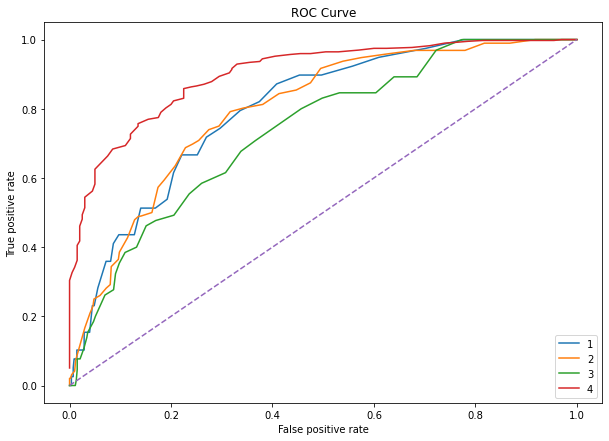

In [679]:
results, roc_data = run_model(model, df_hhh, oversampling=True, view=True)

These results show a high Kaggle score can be obtained by just modeling on the heads of household data without much decrease in the score for the rest of the individuals in the data set. It seems like heads of household data is very different than data for everyone else.

* [model test](#model_test)
* [create_roc_all](#create_roc_all)
* [run_xgb](#run_xgb)
* [run_model](#run_model)
* [gridCV](#gridCV)

In [671]:
feature_rankings = results['feature_importance'].reset_index(drop=True)
feature_rankings[feature_rankings['Feature'] == 'parentesco1']

,Feature,Importance,Cumulative sum
234,parentesco1,0.0,1.0


This feature ranks WAY down in importance (234 out of 248, close to the end) which might explain why the results are so different when modeling based on heads of household and on all individuals. Perhaps additional cleaning needs to happen for heads of household data but that exceeds the time available for this project.

Last thing before we do an exhaustive grid search. Let's see if the number of features really makes a difference by timing how long the full df takes to run and the abridged df.

## Testing modeling time for full and truncated data sets

In [680]:
%%time
results, roc_data = run_model(RandomForestClassifier(n_estimators=100), df_merge_final.join(df.idhogar), oversampling=False, view=False)

CPU times: user 7.28 s, sys: 65.9 ms, total: 7.34 s
Wall time: 7.34 s


In [684]:
%%time
results, roc_data = run_model(model, df_merge_select_features.join([df.Target, df.idhogar, df.parentesco1]), oversampling=False, view=False)

CPU times: user 6.53 s, sys: 19.1 ms, total: 6.54 s
Wall time: 6.54 s


Modeling an abridged version with 91 columns takes  **89%** of the time. Let's just run the full df because even though it will take twice as long, we will get a better prediction.

* [model test](#model_test)
* [create_roc_all](#create_roc_all)
* [run_xgb](#run_xgb)
* [run_model](#run_model)
* [gridCV](#gridCV)
* [Hyperparameter plotting](#hyperPlotting)

<a id='gridCV'></a>

# Hyperparameter tuning

In [689]:
rf = RandomForestClassifier(n_estimators=100)

In [690]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

The features we will test exhaustively were chosen based on which features the link below labels as important to tune.

https://towardsdatascience.com/random-forest-hyperparameters-and-how-to-fine-tune-them-17aee785ee0d

In [760]:
# Random Forest parameters to sweep through
param_grid_rf = { 
    'n_estimators': [10, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
#     'max_depth' : [None,5,6,7,8],
    'criterion' :['gini', 'entropy'],
    'class_weight': ['balanced', None]
#     'oversampling': [True, False]
}

In [786]:
def grid_search(parameters, df, model, view=False):
# uses code from https://stackoverflow.com/questions/3873654/combinations-from-dictionary-with-list-values-using-python

    '''returns exhaustive grid search for RANDOM FOREST algorithm
        return results_set, roc_data_set, parameters_set'''
    
    combinations = [[{key: value} for (key, value) in zip(parameters, values)] 
                for values in it.product(*parameters.values())]
        
    mergedDict_set = []
    mergedDict={}
    for row in combinations:
        for entry in row:
            mergedDict = mergedDict | entry
        mergedDict_set += [mergedDict]
        
    results_set = []
    roc_data_set = []
    parameters_set = []
    
    for param in mergedDict_set:
        parameters_set += [param]
#         oversampling = param['oversampling']
#         del param['oversampling']
        model.set_params(**param)
        results, roc_data = run_model(model, df)
        results_set += [results]
        roc_data_set += [roc_data]
    return results_set, roc_data_set, parameters_set

In [867]:
rfc = RandomForestClassifier()
results_set_rf, roc_data_set_rf, parameters_set_rf = grid_search(param_grid, df_merge_final.join(df.idhogar), rfc)

In [776]:
# Find the conditions that maximize the recall_mean
def find_best_params(results_set, roc_data_set, parameters_set):
    '''returns the highest recall score, roc data for the optimal conditions, and optimal conditions'''
    max_ind = 0
    prev_recall_mean = 0
    for i, results in enumerate(results_set):
        if results_set[i]['recall_mean'] > prev_recall_mean:
            prev_recall_mean = results_set[i]['recall_mean']
            max_ind = i

#     print(parameters_set[max_ind])
#     print(results_set[max_ind]['recall_mean'])
    
    return results_set[max_ind]['recall_mean'], roc_data_set[max_ind], parameters_set[max_ind]

In [868]:
max_recall_rf, best_roc_data_set_rf, best_params_rf = find_best_params(results_set_rf, roc_data_set_rf, parameters_set_rf)
print(max_recall_rf, best_params_rf)

0.3486 {'n_estimators': 100, 'max_features': 'auto', 'criterion': 'gini', 'class_weight': None}


Confirm that these parameters produce the values expected from the model.

In [767]:
rfc = RandomForestClassifier()
rfc.set_params(**best_params_rf)

RandomForestClassifier(class_weight='balanced', max_features='sqrt')

----- Recall Cross-Validation Scores -----
[0.288, 0.378, 0.369, 0.303, 0.34]
Mean recall: 0.336 ± 0.035
Estimated Kaggle score: 0.225


,Feature,Importance,Cumulative sum
121,dependency,0.045410,0.045410
222,r4m3_scaledLugar,0.040997,0.086407
166,elimbasu6_scaledLugar,0.029156,0.115563
223,r4t1_scaledLugar,0.023224,0.138787
122,meaneduc,0.021664,0.160451
...,...,...,...
77,pisoother,0.000005,0.999999
84,techootro,0.000001,1.000000
78,pisonatur,0.000000,1.000000
197,mobilephone_scaledLugar,0.000000,1.000000


,AUC
category,
1,0.746214
2,0.807478
3,0.763274
4,0.881877


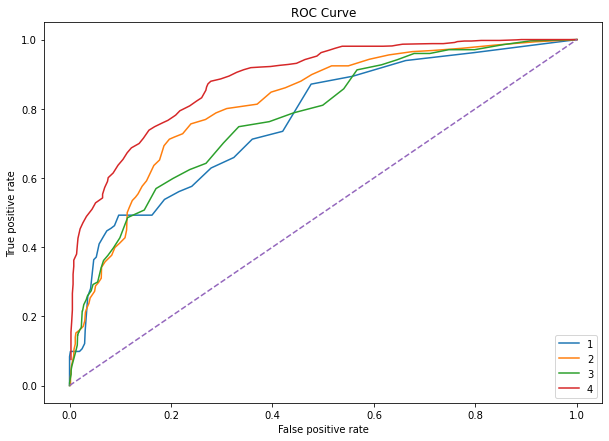

In [768]:
results, roc_data = run_model(rfc, df_merge_final.join(df.idhogar), oversampling=False, view=True)

# Evaluate logistic regression

/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

'LogisticRegression' object has no attribute 'feature_importances_'
'feature_importance'
----- Recall Cross-Validation Scores -----
[0.214, 0.306, 0.321, 0.233, 0.301]
Mean recall: 0.275 ± 0.043
Estimated Kaggle score: 0.205
'feature_importance'


,AUC
category,
1,0.765343
2,0.729953
3,0.641958
4,0.840014


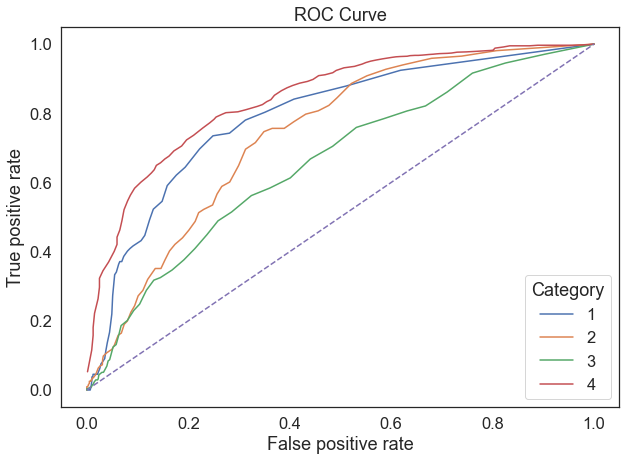

In [1158]:
# Evaluate logistic regression
logreg = LogisticRegression(multi_class='ovr')
results, roc_data = run_model(logreg, df_merge_final.join(df.idhogar), oversampling=False, view=True)

Which features does the model appear to be most sensitive to?

In [1186]:
logreg_coefs = pd.DataFrame(results['model'].coef_[1,:], index=results['model'].feature_names_in_, columns=['Coefficient'])#, name='Category 1 coefficients')
# logreg_coefs.sort_values(ascending=False)
logreg_coefs['Euler_mag'] = pow(math.e, logreg_coefs['Coefficient'])
logreg_coefs.sort_values('Euler_mag', ascending=False)

,Coefficient,Euler_mag
r4t1_scaledLugar,0.580828,1.787519
instlevel1_scaledLugar,0.528817,1.696923
hogar_total_scaledLugar,0.503221,1.654041
pisocemento,0.438223,1.549951
tamviv_scaledLugar,0.368924,1.446178
...,...,...
hogar_mayor_scaledLugar,-0.464559,0.628412
hacdor_scaledLugar,-0.471111,0.624308
tipovivi1_scaledLugar,-0.488701,0.613423
elimbasu3,-0.716371,0.488522


In [751]:
# Try various measures of regularlization
logreg_param_grid = { 
    'C': [10000, 1000, 100, 1]
}

In [792]:
logreg = LogisticRegression(multi_class='ovr')
results_set_logreg, roc_data_set_logreg, parameters_set_logreg = grid_search(logreg_param_grid, df_merge_final.join(df.idhogar), logreg)

/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

'LogisticRegression' object has no attribute 'feature_importances_'
'feature_importance'


/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

'LogisticRegression' object has no attribute 'feature_importances_'
'feature_importance'


/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

'LogisticRegression' object has no attribute 'feature_importances_'
'feature_importance'


/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

'LogisticRegression' object has no attribute 'feature_importances_'
'feature_importance'


In [812]:
max_recall_logreg, best_roc_data_set_logreg, best_params_logreg = find_best_params(results_set_logreg, roc_data_set_logreg, parameters_set_logreg)
print(max_recall_logreg, best_params_logreg)

0.2806 {'C': 1000}


Looks like some regularization actually improved the score.

* [model test](#model_test)
* [create_roc_all](#create_roc_all)
* [run_xgb](#run_xgb)
* [run_model](#run_model)
* [gridCV](#gridCV)
* [Hyperparameter plotting](#hyperPlotting)

<a id=hyperPlotting></a>
## Plotting results of hyperparameter tuning
Now that we've done parameter tuning, let's plot the results.

* `roc_data_set_rf`
* `roc_data_set_logreg`

This is a list of roc data. Each entry is roc data (classes 1,2,3,4) for each parameter condition. To create graphs of ROC curves for each condition, you'll need to loop through the list.

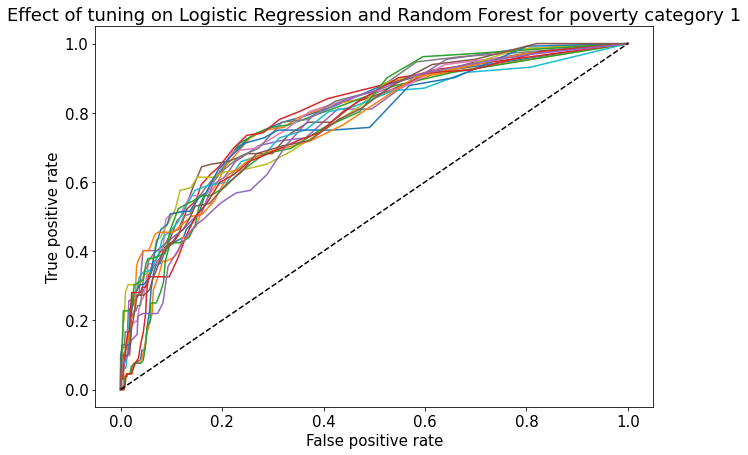

In [1041]:
plt.figure(figsize=(10,7))
for i, roc in enumerate(roc_data_set_logreg + roc_data_set_rf):
    x = roc[1][0]
    y = roc[1][1]
    plt.plot(x, y)
w = np.linspace(0, 1, 10)
plt.plot(w, w, linestyle='--', color='black')
plt.xlabel('False positive rate', fontsize=15)
plt.ylabel('True positive rate', fontsize=15)
plt.title('Effect of tuning on Logistic Regression and Random Forest for poverty category 1')
plt.rc('font', size=15)

There isn't a large effect of tuning or model selection on the AUC. Probably the best thing to do is go back to the data for more cleaning.

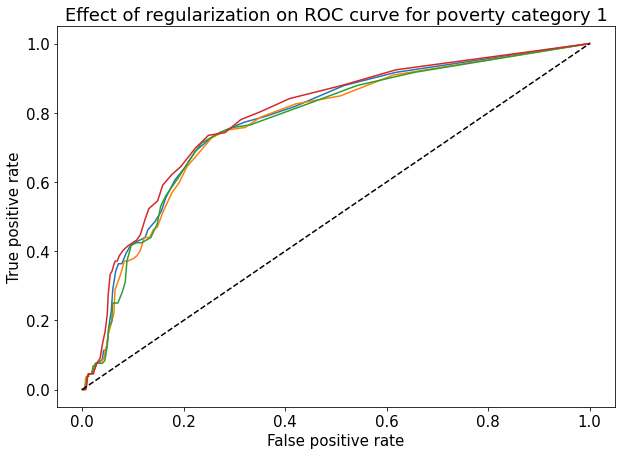

In [959]:
plt.figure(figsize=(10,7))
for i, roc in enumerate(roc_data_set_logreg):
    x = roc[1][0]
    y = roc[1][1]
    plt.plot(x, y)
w = np.linspace(0, 1, 10)
plt.plot(w, w, linestyle='--', color='black')
plt.xlabel('False positive rate', fontsize=15)
plt.ylabel('True positive rate', fontsize=15)
plt.title('Effect of regularization on ROC curve for poverty category 1')
plt.rc('font', size=15)

Now create a table showing AUC for each ROC

In [893]:
result_dict_logreg = {'C': [''], 'recall': [''], 'AUC': ['']}
for i in range(len(results_set_logreg)):
    result_dict_logreg['AUC'] += [results_set_logreg[i]['AUC'].loc[1, 'AUC']]
    result_dict_logreg['C'] += [parameters_set_logreg[i]['C']]
    result_dict_logreg['recall'] += [results_set_logreg[i]['recall_mean']]
result_dict_logreg = pd.DataFrame(result_dict_logreg).iloc[1:]

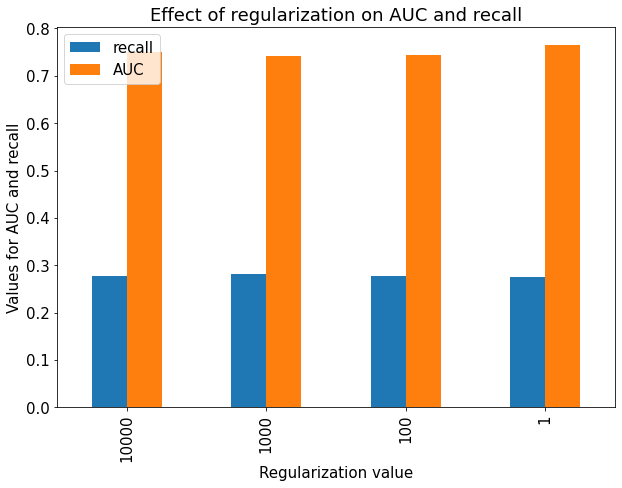

In [963]:
result_dict_logreg.plot(x='C', kind='bar', figsize=(10,7))
plt.title('Effect of regularization on AUC and recall')
plt.xlabel('Regularization value', fontsize=15)
plt.ylabel('Values for AUC and recall')
plt.legend(loc='upper left')
plt.rc('font', size=15)

In [837]:
result_dict_rf = {'C': [''], 'AUC': ['']}
for i in range(len(results_set_rf)):
    result_dict_rf['AUC'] += [result_dict_rf[i]['AUC'].loc[1, 'AUC']]
    result_dict_rf['C'] += [result_dict_rf[i]['C']]
    result_dict_rf['recall'] += [result_dict_rf[i]['recall_mean']]

pd.DataFrame(result_dict_rf).iloc[1:]

,C,AUC
1,10000,0.751167
2,1000,0.740896
3,100,0.743978
4,1,0.765343


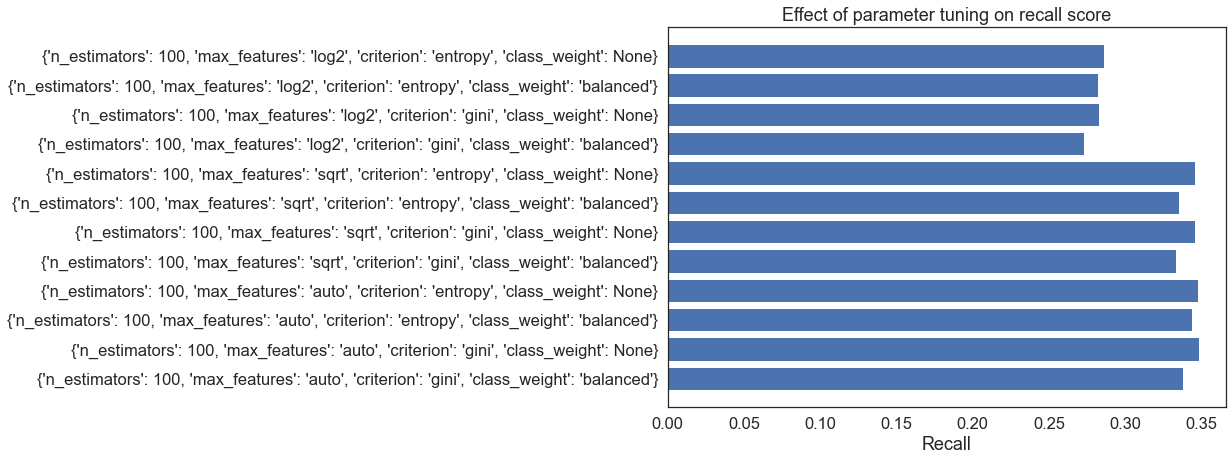

In [1135]:
x = []
y = []
for i in range(len(parameters_set_rf)):
    x += [str(parameters_set_rf[i])]
    y += [results_set_rf[i]['recall_mean']]
plt.figure(figsize=(10,7))
plt.barh(x, y)
plt.xlabel('Recall')
plt.title('Effect of parameter tuning on recall score')
plt.rc('font', size=15)

In [1189]:
# What is max recall?
print(f'Maximum recall: {max(y)}')
print(f'Minimum recall: {min(y)}')
print(f'Parameters for max recall: \n {x[np.argmax(y)]}')
print(f'Parameters for min recall: \n {x[np.argmin(y)]}')

Maximum recall: 0.3486
Minimum recall: 0.273
Parameters for max recall: 
 {'n_estimators': 100, 'max_features': 'auto', 'criterion': 'gini', 'class_weight': None}
Parameters for min recall: 
 {'n_estimators': 100, 'max_features': 'log2', 'criterion': 'gini', 'class_weight': 'balanced'}


The best results are with the default settings on Random Forest. There is clearly a drop in performance when switching max_features from auto or sqrt to log2.

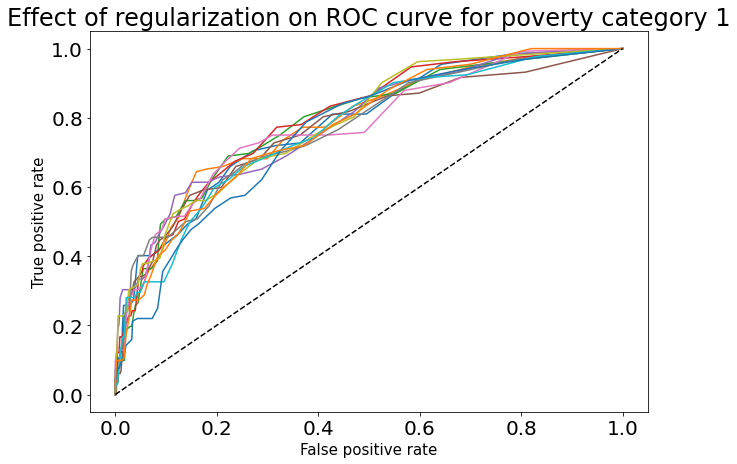

In [951]:
plt.figure(figsize=(10,7))
for i, roc in enumerate(roc_data_set_rf):
    x = roc[1][0]
    y = roc[1][1]
#     print(roc_data_set_rf[i])
    plt.plot(x, y)
w = np.linspace(0, 1, 10)
plt.plot(w, w, linestyle='--', color='black')
plt.xlabel('False positive rate', fontsize=15)
plt.ylabel('True positive rate', fontsize=15)
plt.title('Effect of regularization on ROC curve for poverty category 1')
plt.rc('font', size=20)

In [937]:
result_dict_rf = {}
result_dict_rf['Parameters'] = ['']
result_dict_rf['AUC'] = ['']
result_dict_rf['recall'] = ['']

for i in range(len(results_set_rf)):
    result_dict_rf['Parameters'] += [str(parameters_set_rf[i])]
    result_dict_rf['AUC'] += [results_set_rf[i]['AUC'].loc[1, 'AUC']]
    result_dict_rf['recall'] += [results_set_rf[i]['recall_mean']]

result_dict_rf = pd.DataFrame(result_dict_rf).iloc[1:]

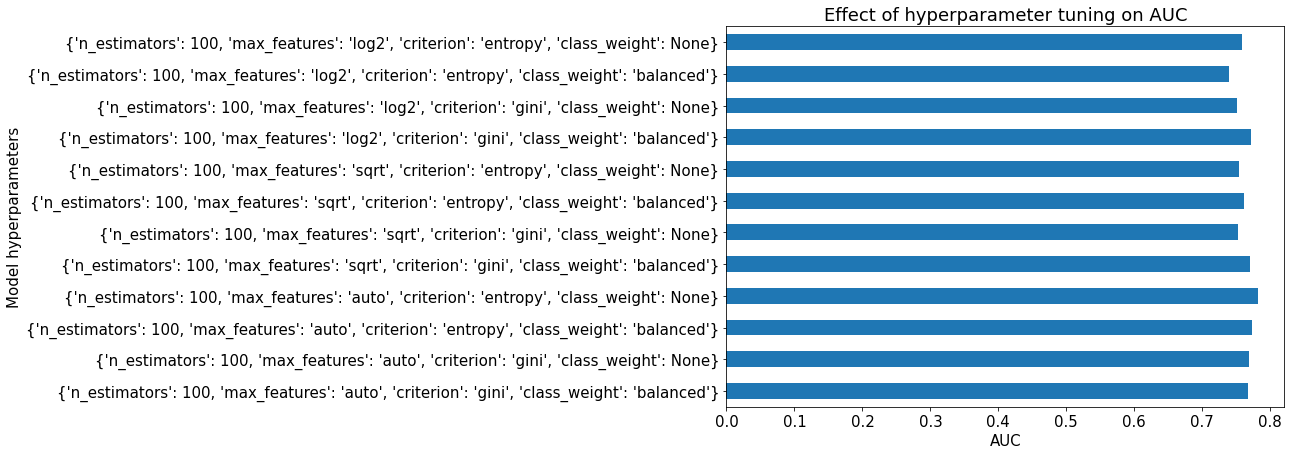

In [949]:
result_dict_rf[['Parameters', 'AUC']].plot(x='Parameters', kind='barh', figsize=(10,7))
plt.title('Effect of hyperparameter tuning on AUC')
plt.xlabel('AUC', fontsize=15)
plt.ylabel('Model hyperparameters')
plt.rc('font', size=15)
plt.gca().get_legend().remove()

In [1143]:
result_dict_logreg_combined = result_dict_logreg.copy()
result_dict_logreg_combined['model'] = 'Logistic regression'
result_dict_rf_combined = result_dict_rf.copy()
result_dict_rf_combined['model'] = 'Random Forest'

In [1125]:
result_dict_logreg_rf_combined = pd.concat([result_dict_logreg_combined[['AUC', 'model']], result_dict_rf_combined[['AUC', 'model']]])
result_dict_logreg_rf_combined.reset_index(drop=True, inplace=True)
result_dict_logreg_rf_combined.index.name = 'Parameter setting'

In [1126]:
# Identify model parameters that maximize AUC

# display(result_dict_logreg_rf_combined.sort_values('AUC', ascending=False))
max_AUC = result_dict_logreg_rf_combined.sort_values('AUC', ascending=False).iloc[0,0]
max_AUC = result_dict_rf_combined[result_dict_rf_combined.AUC == max_AUC].Parameters
full_print(max_AUC)

4    {'n_estimators': 100, 'max_features': 'auto', 'criterion': 'entropy', 'class_weight': None}
Name: Parameters, dtype: object


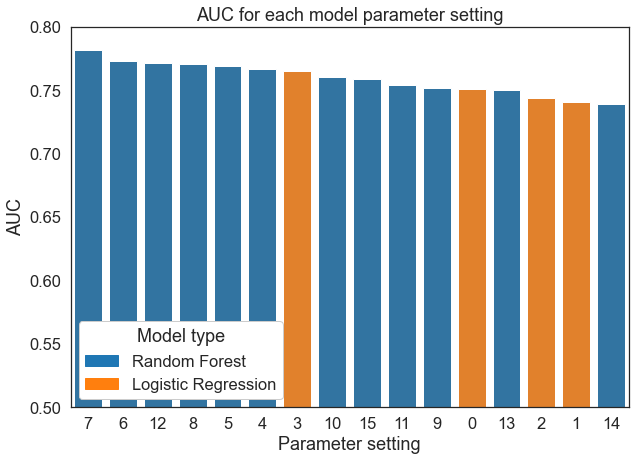

In [1133]:
# sns.barplot(result_dict_logreg_rf_combined)
result_dict_logreg_rf_combined_sorted = result_dict_logreg_rf_combined.sort_values('AUC', ascending=False).reset_index()
colors = ['tab:blue' if c == 'Random Forest' else 'tab:orange' for c in result_dict_logreg_rf_combined_sorted.model]
sns.set(rc={"figure.figsize":(10, 7)}, font_scale = 1.5)
sns.set_style("white")
sns.barplot(data=result_dict_logreg_rf_combined_sorted,
            x='Parameter setting', y='AUC', order=result_dict_logreg_rf_combined_sorted['Parameter setting'],
           palette = colors)
ax = plt.gca()
ax.set_ylim([0.5,0.8])
blue_patch = mpatches.Patch(color='tab:blue', label='Random Forest')
orange_patch = mpatches.Patch(color='tab:orange', label='Logistic Regression')
plt.legend(handles=[blue_patch, orange_patch], loc='lower left', title='Model type', facecolor='white', framealpha=1);
plt.title('AUC for each model parameter setting');
# https://www.geeksforgeeks.org/how-to-manually-add-a-legend-with-a-color-box-on-a-matplotlib-figure/